In [2]:
import numpy as np
from scipy.stats import norm
from scipy.stats import lognorm

import matplotlib.pyplot as plt
import geopandas as gpd

In [3]:
dgwl_file = "C:/Users/paulinkenbrandt/Documents/ArcGIS/Projects/Pahvant/dGWL.gpkg"
dgwl60_22_file = "C:/Users/paulinkenbrandt/Documents/ArcGIS/Projects/Pahvant/dGWL_60_22.gpkg"

# Aquifer Properties

Text(29.222222222222214, 0.5, 'Probability')

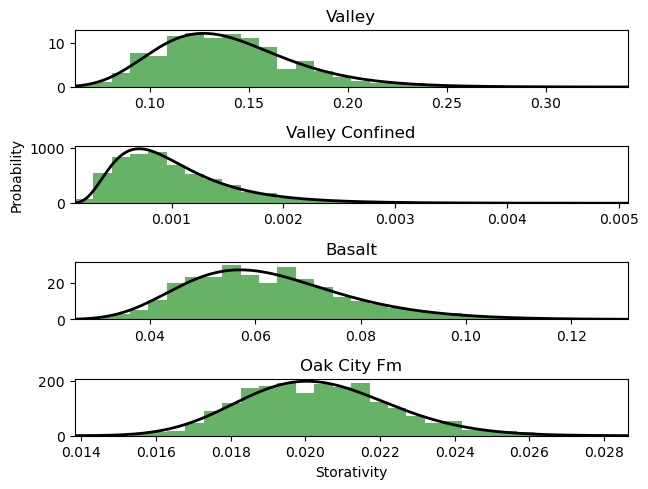

In [58]:

# Parameters for the underlying distribution
dist_params = {'Valley':[np.exp(-2),0.25],
               'Valley Confined':[np.exp(-7),0.5],
               'Basalt':[np.exp(-2.8),0.25],
               'Oak City Fm':[np.exp(-3.9),0.1],
               }

fig, ax = plt.subplots(4,1)

i = 0
for key,val in dist_params.items():
    # Create a lognormal distribution
    # scipy's lognorm takes sigma as the shape parameter and scale = exp(mu)
    dist = lognorm(s=val[1],scale=val[0])
    # Generate values from this distribution
    values = dist.rvs(size=1000)
    # Plot the histogram of the generated values
    ax[i].hist(values, bins=30, density=True, alpha=0.6, color='g')
    
    x = np.geomspace(min(values), max(values), 2000)
    # Plot the probability density function (PDF) of the lognormal distribution
    ax[i].plot(x, dist.pdf(x), 'k-', linewidth=2, label=key)
    ax[i].set_title(key)
    ax[i].set_xlim([min(values), max(values)])
    i += 1
plt.tight_layout()
ax[3].set_xlabel('Storativity')
ax[1].set_ylabel('Probability')
#plt.xscale('log')
#title = f"Fit results: mu = {mu:.2f}, sigma = {sigma:.2f}"
#lt.title(title)
#plt.show()

# Model Total Storage Changes

In [59]:
dgwl = gpd.read_file(dgwl_file)
dgwl60_22 = gpd.read_file(dgwl60_22_file)


aquifer_scale, aquifer_s = [{key : value[i] for key, value in dist_params.items()} for i in range(2)]

dgwl.set_index('ID', inplace=True)
dgwl['s'] = dgwl['Bdrk_v_Valley'].map(aquifer_s)
dgwl['scale'] = dgwl['Bdrk_v_Valley'].map(aquifer_scale)

storage_change_params = {}
storage_changes={}
storage_arrays = []
# Define the parameters for the distributions

for ind in dgwl.index:
    df = dgwl.loc[ind]
    aquifer_area = df['AREA']  # in square meters

    # Groundwater level change parameters (mean and standard deviation)
    gw_level_change_mean = df['MEAN'] * 0.3048  # in meters
    gw_level_change_std = np.abs(gw_level_change_mean * 0.10)  # in meters

    # Average storativity parameters (mean and standard deviation)
    storativity_mean = df['s']  # dimensionless
    storativity_std = df['scale']  # dimensionless

    # Create distributions
    gw_level_change_dist = norm(gw_level_change_mean, gw_level_change_std)
    storativity_dist = lognorm(s=storativity_mean, scale=storativity_std)

    # Sample from distributions
    samples = 10000  # Number of samples to draw
    gw_level_changes = gw_level_change_dist.rvs(samples)
    storativities = storativity_dist.rvs(samples)

    # Calculate groundwater storage changes
    storage_changes = aquifer_area * gw_level_changes * storativities * 0.000810714
    storage_arrays.append(storage_changes)

years_between_wl = 2022-1988
total_storage_change = np.sum(storage_arrays,axis=0)
yearly_storage_change = total_storage_change/years_between_wl

years_between_wl = 2022-1986
years_between_wl_past = 2022-1960

storage_change_params = lognorm.fit(yearly_storage_change)
distribution = lognorm(*storage_change_params)
print(storage_change_params)
print(np.median(yearly_storage_change))


sample_size = 1000
sample = distribution.rvs(size=sample_size)

# Compute the log of the sample
log_sample = np.log(sample)

# Calculate the parameters of the underlying normal distribution
mu = np.mean(log_sample)
sigma = np.std(log_sample)

# Calculate the standard deviation of the lognormal distribution
lognormal_std_dev = np.sqrt((np.exp(sigma ** 2) - 1) * np.exp(2 * mu + sigma ** 2))

print(f"Estimated standard deviation of the lognormal distribution: {lognormal_std_dev}")







(0.1391848674247836, 8028.278468059402, 52415.36046945026)
60371.70803852239
Estimated standard deviation of the lognormal distribution: 7147.05932187008


In [60]:
total_discharge

array([138073.56148206, 149171.21151407, 144578.04791476, ...,
       143033.35447824, 139031.73888555, 159931.75509359])

150748.71459512628 8111.085716878561


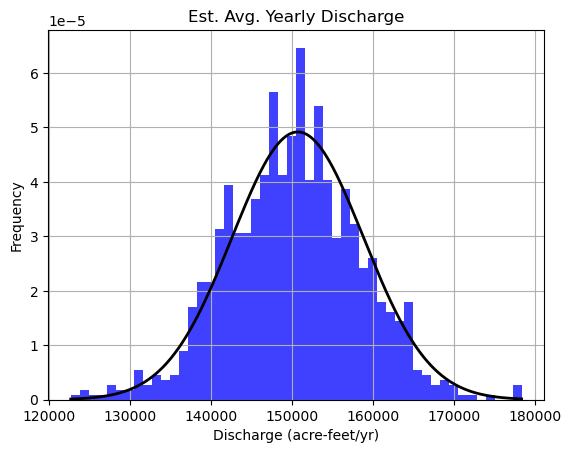

In [61]:
well_mean = 145603
well_std = 7880

et_mean = 5072
et_std = 1663

well_pump = norm(well_mean, well_std)
et_spring_q = norm(et_mean, et_std)

total_discharge = np.sum([well_pump.rvs(size=10000), et_spring_q.rvs(size=10000)], axis=0)


totald_param = norm.fit(total_discharge)
dis_dist = norm(*totald_param)

print(*totald_param)


values = dis_dist.rvs(size=1000)
# Plot the probability density function (PDF) of the lognormal distribution
x = np.geomspace(min(values), max(values), 2000)

fig, ax  =plt.subplots(1, 1)
ax.hist(values, bins=50, alpha=0.75, color='blue',density=True)
ax.plot(x, dis_dist.pdf(x), 'k-', linewidth=2)
ax.set_title(f'Est. Avg. Yearly Discharge')
ax.set_xlabel('Discharge (acre-feet/yr)')
ax.set_ylabel('Frequency')
ax.grid(True)

89133.90037785606 11717.006953594744


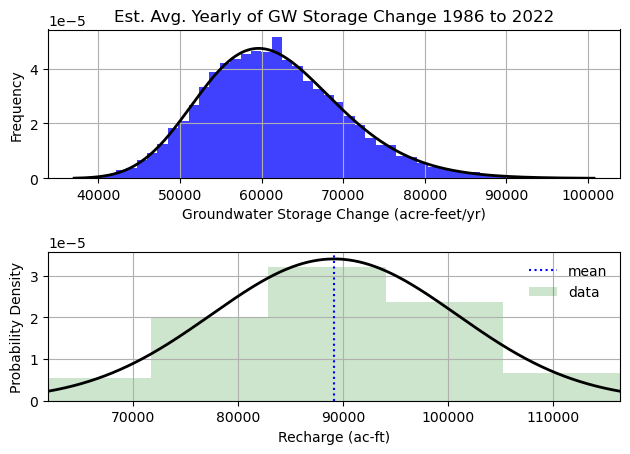

In [57]:
well_mean = 145603
well_std = 7880

et_mean = 5072
et_std = 1663

well_pump = norm(well_mean, well_std)
et_spring_q = norm(et_mean, et_std)
storage_change = lognorm(*storage_change_params)

total_rech = []

for i in range(10000):
    total_rech.append(well_pump.rvs(size=1)[0] + et_spring_q.rvs(size=1)[0] - storage_change.rvs(size=1)[0])


totalr_param = norm.fit(total_rech)
rech_dist = norm(*totalr_param)
print(*totalr_param)
fig, ax = plt.subplots(2, 1)

# Plot the probability density function (PDF) of the lognormal distribution
#x = np.geomspace(min(yearly_storage_change), max(yearly_storage_change), 2000)
x = np.linspace(min(yearly_storage_change), max(yearly_storage_change), 2000)
ax[0].hist(yearly_storage_change, bins=50, alpha=0.75, color='blue',density=True)
ax[0].plot(x, distribution.pdf(x), 'k-', linewidth=2)
ax[0].set_title(f'Est. Avg. Yearly of GW Storage Change 1986 to 2022')
ax[0].set_xlabel('Groundwater Storage Change (acre-feet/yr)')
ax[0].set_ylabel('Frequency')
ax[0].grid(True)





r = rech_dist.rvs(size=1000)
x = np.linspace(rech_dist.ppf(0.01), rech_dist.ppf(0.99), 1000)
ax[1].plot(x, rech_dist.pdf(x), 'k-', lw=2)
#ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
#ax[1].axvline(rech_dist.median(),label='median',color='red',linestyle=":")
ax[1].axvline(rech_dist.mean(),label='mean',color='blue',linestyle=":")
ax[1].hist(total_rech, density=True, color='green',alpha=0.2,label='data')
#ax.axvspan(*testdist.interval(0.80),alpha=0.2,color='green')
ax[1].set_xlim([x[0], x[-1]])
ax[1].set_xlabel('Recharge (ac-ft)')
ax[1].set_ylabel("Probability Density")
ax[1].legend(loc='best', frameon=False)
ax[1].grid(True)
plt.tight_layout()
plt.savefig("")

In [49]:
storage_change.mean()

62555.22508027166

In [48]:
rech_dist.median()

88142.50736627005

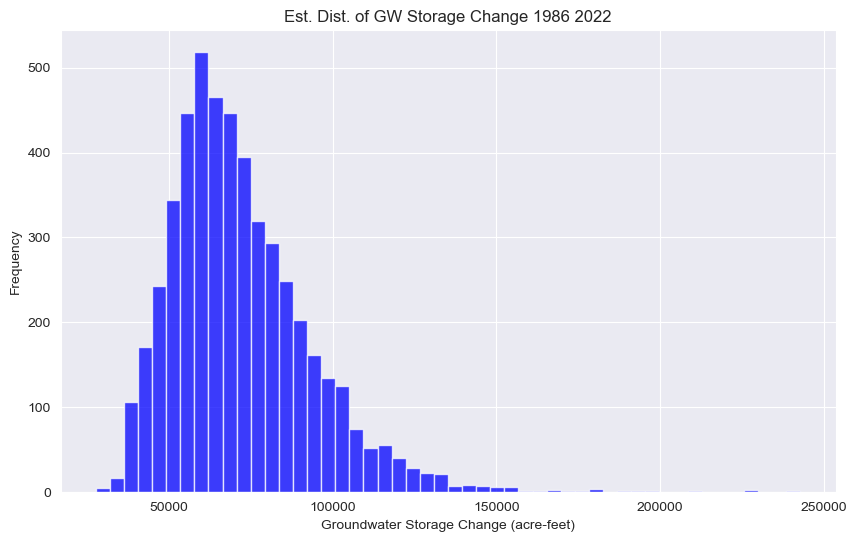

In [222]:
for i in range(5000):
    irr_pumping = np.sum(pump_dur_dist.rvs(size=n_irr_wells) * 24 * 60 * testdist.rvs(size=n_irr_wells) * 3.06889e-6)
    dom_pumping = np.sum(dom_gpm_dist.rvs(size=n_dom_wells ) * 60 * dom_hr_dist.rvs(size=n_dom_wells) * 365.25 * 3.06889e-6)
    stk_pumping = np.sum(stk_gpm_dist.rvs(size=n_stk_wells)* 60 * stk_hr_dist.rvs(size=n_stk_wells) * stk_day_dist.rvs(size=n_stk_wells) * 3.06889e-6)
    mun_pumping = mun_pumping_dist.rvs(size=1)[0]
    ind_pumping = ind_pumping_dist.rvs(size=1)[0]

    total_irr_pumped_model.append(irr_pumping)
    total_dom_pumped_model.append(dom_pumping)
    total_stk_pumped_model.append(stk_pumping)
    total_pumping_model.append(np.sum([irr_pumping,dom_pumping,stk_pumping,mun_pumping,ind_pumping]))

In [169]:
years_between_wl = 2022-1986
years_between_wl_past = 2022-1960

stor = 0
for key,val in storage_change_params.items():
    stor+=val[0]
stor/36

36

In [237]:
2022-1988

34

In [171]:
storage_change_params

{2: (164596.0068448799, 103613.8074909148),
 3: (807559.6941756358, 500730.65086660907),
 4: (622030.2667795037, 386683.47133335454),
 5: (596378.5096949679, 370272.96851613745),
 6: (254641.19238376632, 154928.8363344997),
 7: (155994.60413340584, 97402.26505785849),
 8: (-6.51139831595385, 1.1737777665224698),
 10: (82.2822492956876, 15.045587633135153),
 11: (65.88632537672967, 11.98375166974957),
 12: (27.96020128957728, 5.0518106851095155),
 14: (0.0, 0.0),
 15: (174862.94418084543, 99062.99931227192),
 16: (455.9388042391547, 513.8439381731545),
 17: (23.18819121702311, 27.1490848516297),
 19: (83.43025357462237, 95.4638613942015),
 20: (476.0206187584367, 534.3888755209283),
 21: (690.7041133179546, 794.2182395342664)}

79357.1634593717